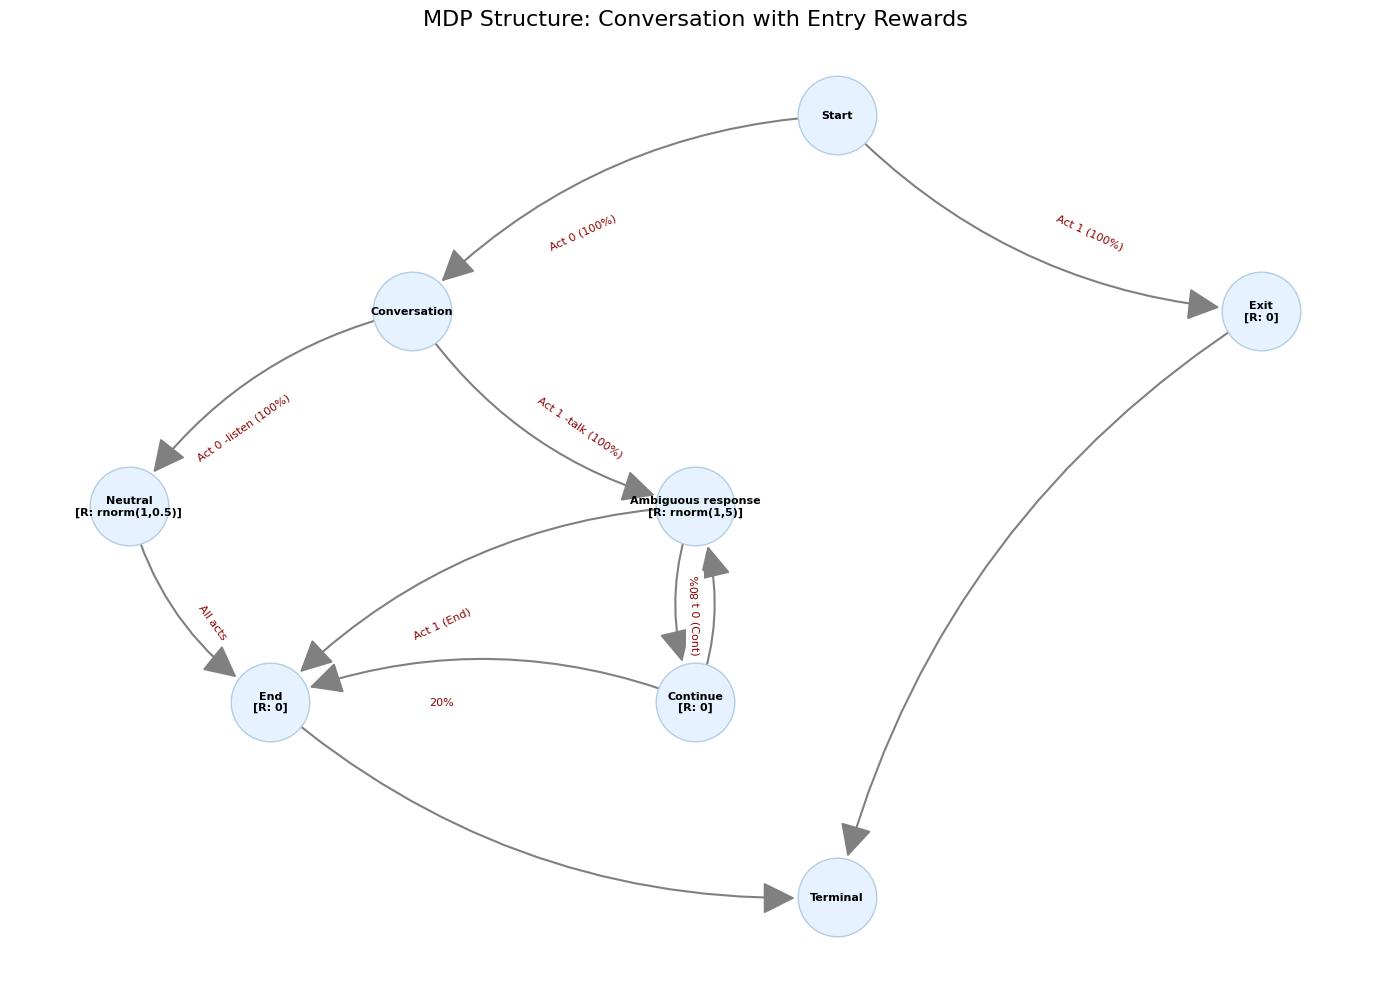

In [1]:
# ------------------------------------------------------------
# 5. VISUALIZATION FUNCTION (Paste this at the end)
# ------------------------------------------------------------
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
def visualize_mdp():
    """
    Plots the new "Conversation vs Exit" MDP structure.
    Visualizes rewards as Entry/Exit rewards within the nodes.
    """
    # 1. Define Nodes (States) with Reward info embedded
    node_labels = {
        0: "Start",
        # Level 1
        1: "Conversation",
        2: "Exit\n[R: 0]",
        # Level 2 (Reactions)
        3: "Neutral\n[R: rnorm(1,0.5)]",
        4: "Ambiguous response\n[R: rnorm(1,5)]",
        # Level 3 (Outcomes)
        5: "Continue\n[R: 0]",
        6: "End\n[R: 0]",
        7: "Terminal",
    }

    # 2. Define Edges (Transitions)
    edges = [
        # Start -> Conversation / Exit
        (0, 1, "Act 0 (100%)"),
        (0, 2, "Act 1 (100%)"),
        # Exit -> Terminal
        (2, 7, ""),
        # Conversation -> Neutral / Ambiguous
        (1, 3, "Act 0 -listen (100%)"),
        (1, 4, "Act 1 -talk (100%)"),
        # Neutral ->  End
        (3, 6, "All acts"),
        # Ambiguous -> Continue / End
        (4, 5, "Act 0 (Cont)"),
        (4, 6, "Act 1 (End)"),
        # Continue -> Same responses
        (5, 4, "80%"),
        (5, 6, "20%"),
        # Outcomes -> Terminal
        (6, 7, ""),
    ]

    # 3. Build Graph
    G = nx.DiGraph()
    for n, label in node_labels.items():
        G.add_node(n, label=label)

    for u, v, label in edges:
        G.add_edge(u, v, label=label)

    # 4. Set Positions (Tree Layout)
    pos = {
        0: (0, 10),  # Start
        1: (-3, 8),
        2: (3, 8),  # Level 1: Conversation vs Exit
        3: (-5, 6),
        4: (-1, 6),  # Level 2: Neutral vs Nod
        5: (-1, 4),
        6: (-4, 4),  # Level 3: Continue vs End
        7: (0, 2),  # Terminal
    }

    # 5. Draw
    plt.figure(figsize=(14, 10))

    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos, node_size=3200, node_color="#e6f2ff", edgecolors="#b3cde3"
    )

    # Draw Labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight="bold")

    # Draw Edges
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color="gray",
        arrows=True,
        arrowsize=50,
        width=1.5,
        connectionstyle="arc3,rad=0.2",
        min_target_margin=30,
    )

    # Draw Edge Labels
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_size=8,
        label_pos=0.6,
        font_color="darkred",
    )

    plt.title("MDP Structure: Conversation with Entry Rewards", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("mdp_structure_visual.png", dpi=300)
    plt.show()


# Run the visualization
visualize_mdp()


# Visualize Social MDP

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns 
import networkx as nx
from tqdm import tqdm

sns.set(style="white", font_scale=1.2)

# ------------------------------------------------------------
# 0. Global Constants & State Definitions
# ------------------------------------------------------------

# State Mapping
STATE_START = 0
STATE_START_CONVERSATION = 1
STATE_RUN_AWAY = 2

# Level 2 (Reactions)
STATE_NEUTRAL = 3
STATE_NOD = 4
STATE_CONTINUE = 5
STATE_END = 6

STATE_TERMINAL = 7

N_STATES = 8
N_ACTIONS = 2

STATE_NAMES = {
    0: "Start",
    1: "Conversation",
    2: "Exit",
    3: "Neutral response",
    4: "Ambiguous response",
    5: "Continue",
    6: "End",
    7: "Terminal",
}

# ------------------------------------------------------------
# 1. Helper Functions
# ------------------------------------------------------------

def softmax(q_values, beta):
    """Compute softmax probabilities."""
    e_x = np.exp(beta * (q_values - np.max(q_values)))
    return e_x / e_x.sum()

def get_next_state_and_reward(
    state, action, is_key_trial=False, force_outcome_neg=False
):
    """
    Probabilistic Decision Tree Step.
    """
    next_state = state
    reward = 0.0

    # --- Level 0: Start -> Conversation or Exit ---
    if state == STATE_START:
        if action == 0:
            probs = [1, 0]
        else:
            probs = [0, 1]
        next_state = np.random.choice(
            [STATE_START_CONVERSATION, STATE_RUN_AWAY], p=probs
        )

        if next_state == STATE_RUN_AWAY:
            reward = 0

    # --- Level 1: Conversation -> Reaction ---
    elif state == STATE_START_CONVERSATION:
        # Action 0(talk): 100% Ambiguous
        # Action 1(listen): 100% Nod
        if action == 0:
            next_state = np.random.choice([STATE_NEUTRAL, STATE_NOD], p=[0, 1])
        else:
            next_state = np.random.choice([STATE_NEUTRAL, STATE_NOD], p=[0, 1])

        if next_state == STATE_NOD:
            reward = np.random.normal(loc=1, scale=5)
        else:
            reward = np.random.normal(loc=1, scale=0.5)

    elif state == STATE_RUN_AWAY:
        next_state = STATE_TERMINAL
        reward = 0

    # --- Level 2: Reaction -> Outcome ---
    elif state in [STATE_NOD, STATE_NEUTRAL]:
        if state == STATE_NOD:
            # Nod branch: Continue (Reward) or End (Zero)
            if action == 0:
                next_state = STATE_CONTINUE
                reward = 0.0
            else:
                next_state = STATE_END
                reward = 0.0
        else:
            # Neutral branch: Always ends
            next_state = STATE_END
            reward = 0.0

    # --- Level 4: Continue ->  ---
    elif state in [STATE_CONTINUE]:
        next_state = np.random.choice([STATE_NOD, STATE_END], p=[0.8, 0.2])
        reward = 0.0

    # --- Level 4: Outcomes -> Terminal ---
    elif state in [STATE_END]:
        next_state = STATE_TERMINAL
        reward = 0.0

    elif state == STATE_TERMINAL:
        next_state = STATE_TERMINAL
        reward = 0.0

    return next_state, reward


def step_explore_sr(state, action):
    """Simplified step for SR learning."""
    next_s, _ = get_next_state_and_reward(state, action)
    return next_s, 0



In [3]:
# ------------------------------------------------------------
# 2. Simulation Logic
# ------------------------------------------------------------

def simulate_condition(
    agent_type: str = "none",
    first_outcome: str = "none",
    key_trial_idx: int = -1,
    tau: float = 0.1,
    n_episodes: int = 20,
    n_steps_explore: int = 200,
    alpha: float = 0.1,
    gam_anx: float = 0.40,
    gam_healthy: float = 0.50,
    gamma_learn: float = 0.9,
    beta: float = 1.0,
    burst_max: int = 50,
    use_descending_lr: bool = True,
):
    # ---------- Initialise value and SR ----------------------
    Q = np.zeros((N_STATES, N_ACTIONS))
    SR = np.eye(N_STATES)

    update_counts_RWD = np.zeros((N_STATES, N_ACTIONS), dtype=int)
    update_counts_SR = np.zeros(N_STATES, dtype=int)

    memory = []
    memory_PEP = []

    total_replay = 0
    total_reward = 0

    episode_stats = []

    def alpha_RWD(st, a):
        n = update_counts_RWD[st, a]
        return 1.0 if n == 0 else 1.0 / n

    # ---------- REPLAY LOGIC -------------------------
    def replay_burst(curr_state):
        n_burst = 0
        V_cost = np.dot(softmax(Q[curr_state], beta), Q[curr_state])

        nonlocal total_replay, gam_anx, gam_healthy
        while n_burst < burst_max:
            best_evb_c, best_mem = 0, 0
            memory_counter = 0
            for s_mem, a_mem, r_mem, s2_mem, td_mem in memory:
                # SR lookup
                need = SR[curr_state, s_mem]
                q_old = Q[s_mem, a_mem]
                td = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old

                if use_descending_lr:
                    a_mem_lr = alpha_RWD(s_mem, a_mem)
                else:
                    a_mem_lr = alpha
                q_new = q_old + a_mem_lr * td

                q_tmp = Q[s_mem].copy()
                q_tmp_old = Q[s_mem].copy()
                q_tmp[a_mem] = q_new
                new_policy_v = np.dot(softmax(q_tmp, beta), q_tmp)
                old_policy_v = np.dot(softmax(Q[s_mem], beta), q_tmp_old)

                # EVB Calculation
                evb_c = np.abs(a_mem_lr * td_mem) - (old_policy_v / 5)

                if evb_c > best_evb_c:
                    best_evb_c, best_mem = evb_c, (s_mem, a_mem, q_new, r_mem)
                    best_mem_counter = memory_counter
                memory_counter += 1

            eps = 0.5
            if best_evb_c <= 0 + eps:
                break

            s_b, a_b, q_new_b, r_b = best_mem
            if use_descending_lr:
                update_counts_RWD[s_b, a_b] += 1
            Q[s_b, a_b] = q_new_b

            my_list = list(memory[best_mem_counter])
            my_list[4] = td
            new_memory = tuple(my_list)
            memory[best_mem_counter] = new_memory
            total_replay += 1
            n_burst += 1

    def replay_burst_PEP(specific_memory):
        n_burst = 0

        nonlocal total_replay, gam_anx, gam_healthy
        while n_burst < burst_max:
            s_mem, a_mem, r_mem, s2_mem, td_mem = specific_memory

            q_old = Q[s_mem, a_mem]

            td = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old

            if use_descending_lr:
                a_mem_lr = alpha_RWD(s_mem, a_mem)
            else:
                a_mem_lr = alpha

            q_new = q_old + a_mem_lr * td

            q_tmp = Q[s_mem].copy()
            q_valueOld = np.dot(softmax(Q[s_mem], beta), q_tmp)

            evb_c = np.abs(a_mem_lr * td) - (q_valueOld / 5)

            best_mem = (s_mem, a_mem, q_new, r_mem)

            eps = 0
            if evb_c <= 0 + eps:
                break
            s_b, a_b, q_new_b, r_b = best_mem
            if use_descending_lr:
                update_counts_RWD[s_b, a_b] += 1
            Q[s_b, a_b] = q_new_b

            total_replay += 1
            n_burst += 1

    # ----------------------------------------------------------
    # Pre-training SR
    # ----------------------------------------------------------
    s_t = STATE_START
    for _ in range(n_steps_explore):
        a_t = np.random.choice(N_ACTIONS)
        s_next, _ = step_explore_sr(s_t, a_t)

        lr = alpha
        one_hot = np.zeros(N_STATES)
        one_hot[s_t] = 1.0
        SR[s_t, :] += lr * (one_hot + gamma_learn * SR[s_next, :] - SR[s_t, :])

        if s_next == STATE_TERMINAL:
            s_t = STATE_START
        else:
            s_t = s_next

    # ----------------------------------------------------------
    # Main Online Episodes
    # ----------------------------------------------------------
    for e in range(n_episodes):
        start_replay_count = total_replay
        s_t = STATE_START

        is_key_ep = e == key_trial_idx

        ep_reward = 0
        step_count = 0
        speaking_count=0

        while s_t != STATE_TERMINAL and step_count < 15:
            step_count += 1

            # Action Selection
            q_vals = Q[s_t]
            p_vals = softmax(q_vals, beta)
            a_t = np.random.choice(N_ACTIONS, p=p_vals)

            # --- Optional Key Trial Manipulation ---
            force_neg = False
            if is_key_ep and first_outcome == "Negative":
                force_neg = True
                if s_t == STATE_START:
                    a_t = 0  # Force Convo (Group 1)
                if s_t == STATE_START_CONVERSATION:
                    a_t = 1  # Force Joke -> High Prob of Nod

            if is_key_ep and first_outcome == "Positive":
                if s_t == STATE_START:
                    a_t = 0  # Force Convo (Group 1)
                if s_t == STATE_START_CONVERSATION:
                    a_t = 1  # Force Joke -> High Prob of Nod

            # Execute Step
            s_next, r_t = get_next_state_and_reward(
                s_t, a_t, is_key_trial=is_key_ep, force_outcome_neg=force_neg
            )

            if (s_next in [STATE_CONTINUE,STATE_START_CONVERSATION]):
                speaking_count = speaking_count+1
                
            # Learning
            if use_descending_lr:
                update_counts_RWD[s_t, a_t] += 1
                a_lr = alpha_RWD(s_t, a_t)
            else:
                a_lr = alpha

            td = r_t + (gamma_learn * np.max(Q[s_next])) - Q[s_t, a_t]
            Q[s_t, a_t] += a_lr * td

            # Memory
            memory.append((s_t, a_t, r_t, s_next, td))
            memory = memory[-25:]

            # --- Replay ---
            replay_burst(s_t)

            # --- PEP Replay ---
            q_tmp_old = Q[s_t].copy()
            old_policy_v = np.dot(softmax(Q[s_t], beta), q_tmp_old)
            evb_c = np.abs(a_lr * td) - (old_policy_v / 5)
            if evb_c > 0.1:
                memory_PEP.append((s_t, a_t, r_t, s_next, td))

            ep_reward += r_t
            s_t = s_next

        # Stats
        avg_q = np.mean(np.max(Q, axis=1))
        replays_in_ep = total_replay - start_replay_count
        episode_stats.append(
            {
                "Episode": e,
                "Replays": replays_in_ep,
                "AvgQ": avg_q,
                "TotalReward": ep_reward,
                "SpeakingCount":speaking_count
            }
        )

    return episode_stats


In [ ]:
# ------------------------------------------------------------
# 3. Parameter Sweep & Execution
# ------------------------------------------------------------

n_eps = 20
n_subjs = 1000
episode_records = []

print("Running Simulation...")

for run in tqdm(range(n_subjs)):
    ep_stats = simulate_condition(
        n_episodes=n_eps,
    )

    for stat in ep_stats:
        episode_records.append(
            {
                "Run": run,
                "Episode": stat["Episode"],
                "Replays": stat["Replays"],
                "AvgQ": stat["AvgQ"],
                "TotalReward": stat["TotalReward"],
                "SpeakingCount":stat["SpeakingCount"]
            }
        )

df_episodes = pd.DataFrame(episode_records)


Running Simulation...


<positron-console-cell-7>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\owner\AppData\Roaming\Python\Python314\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_summary : Removed 20000 rows containing non-finite values.


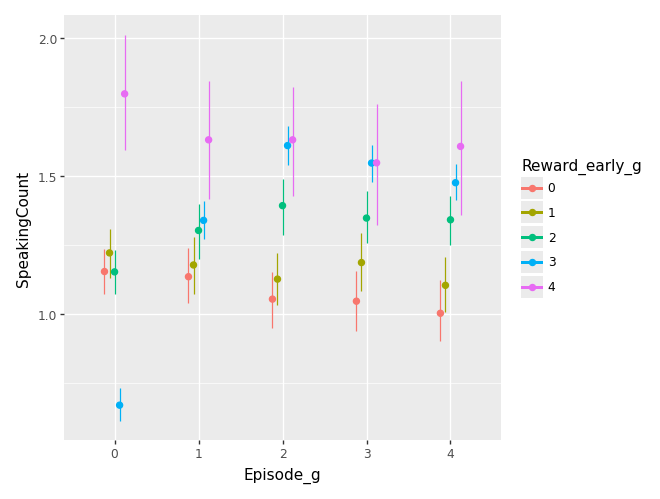

In [7]:
from plotnine import (
    ggplot,
    aes,
    theme_bw,
    stat_summary,
    geom_point,
    theme,
    position_dodge,
)

df_episodes["Episode_g"] = pd.cut(df_episodes["Episode"], bins=5, labels=False).astype(
    "category"
)

# 2. Group by Subj and find MinReward (mutate equivalent)
# We filter TotalReward where Episode_g is 1, then find the min per Subj
df_episodes["Reward_early"] = df_episodes.groupby("Run")["TotalReward"].transform(
    lambda x: x[df_episodes.loc[x.index, "Episode_g"] == 0].min()
)

# 3. Create MinReward groups (cut_number equivalent)
df_episodes["Reward_early_g"] = pd.qcut(
    df_episodes["Reward_early"], q=5, labels=False
).astype("category")

# 4. Summarize (group_by + summarize equivalent)
df_episodes_agg = (
    df_episodes.groupby(["Run", "Episode_g", "Reward_early_g"])
    .agg(SpeakingCount=("SpeakingCount", "mean"), Replay=("Replays", "mean"))
    .reset_index()
)

# 5. Visualizations
# Plot 1: SpeakingCount
p1 = ggplot(
    df_episodes_agg,
    aes(
        x="Episode_g", y="SpeakingCount", color="Reward_early_g", group="Reward_early_g"
    ),
) + stat_summary(position=position_dodge(0.3) + theme_bw())

# Plot 2: Replay
p2 = ggplot(
    df_episodes_agg,
    aes(x="Episode_g", y="Replay", color="Reward_early_g", group="Reward_early_g"),
) + stat_summary(position=position_dodge(0.3) + theme_bw())

p1
#p2
